#### Creating a model for the https://www.kaggle.com/datasets/gpiosenka/cards-image-datasetclassification dataset.

This notebook uses the VGG16 model without the initial weights:

Results:

accuracy: 93%

f1-score: 93%

precision: 94.5%

recall: 94%

In [1]:
extensions_loaded = False
if not extensions_loaded:
    %load_ext autoreload
    %load_ext tensorboard
    extensions_loaded = True

%autoreload 2
%matplotlib inline

# Initial setup for all models.

In [2]:
import sys
import os
import random

import so_ml_tools as soml

import tensorflow as tf
import keras as ks
import pandas as pd
import numpy as np
import opendatasets as od

import tensorflow_hub as hub

from keras import Model
from keras import layers
from keras import losses
from keras import optimizers

2023-09-28 18:56:07.823983: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Download Kaggle Card Image Dataset

In [3]:
od.download_kaggle_dataset(dataset_url="https://www.kaggle.com/datasets/gpiosenka/cards-image-datasetclassification/download?datasetVersionNumber=2", data_dir="./data")

Skipping, found downloaded files in "./data/cards-image-datasetclassification" (use force=True to force download)


### Inspect Dataset

In [4]:
# List the contents of the ./data directory
!ls ./data

/bin/bash: /home/sodeso/anaconda3/envs/ml/lib/libtinfo.so.6: no version information available (required by /bin/bash)
cards-image-datasetclassification


In [5]:
# List the contents of the ./data/cards-image-datasetclassification directory
!ls ./data/cards-image-datasetclassification

/bin/bash: /home/sodeso/anaconda3/envs/ml/lib/libtinfo.so.6: no version information available (required by /bin/bash)
cards.csv  test  train	valid


In [6]:
# Delete the two saved models
!rm ./data/cards-image-datasetclassification/*.h5
!ls ./data/cards-image-datasetclassification

/bin/bash: /home/sodeso/anaconda3/envs/ml/lib/libtinfo.so.6: no version information available (required by /bin/bash)
rm: cannot remove './data/cards-image-datasetclassification/*.h5': No such file or directory
/bin/bash: /home/sodeso/anaconda3/envs/ml/lib/libtinfo.so.6: no version information available (required by /bin/bash)
cards.csv  test  train	valid


In [7]:
TRAIN_DIR = './data/cards-image-datasetclassification/train'
TEST_DIR = './data/cards-image-datasetclassification/test'
VALID_DIR = './data/cards-image-datasetclassification/valid'

In [8]:
soml.util.io.list_dir_summary(folder=TRAIN_DIR)

There are 53 directories, and 0 in ./data/cards-image-datasetclassification/train
There are 0 directories, and 152 in ./data/cards-image-datasetclassification/train/six of clubs
There are 0 directories, and 128 in ./data/cards-image-datasetclassification/train/king of clubs
There are 0 directories, and 161 in ./data/cards-image-datasetclassification/train/queen of clubs
There are 0 directories, and 129 in ./data/cards-image-datasetclassification/train/nine of diamonds
There are 0 directories, and 139 in ./data/cards-image-datasetclassification/train/six of diamonds
There are 0 directories, and 139 in ./data/cards-image-datasetclassification/train/queen of hearts
There are 0 directories, and 151 in ./data/cards-image-datasetclassification/train/ten of diamonds
There are 0 directories, and 151 in ./data/cards-image-datasetclassification/train/king of spades
There are 0 directories, and 126 in ./data/cards-image-datasetclassification/train/three of clubs
There are 0 directories, and 157 i

### Visualize some sample data

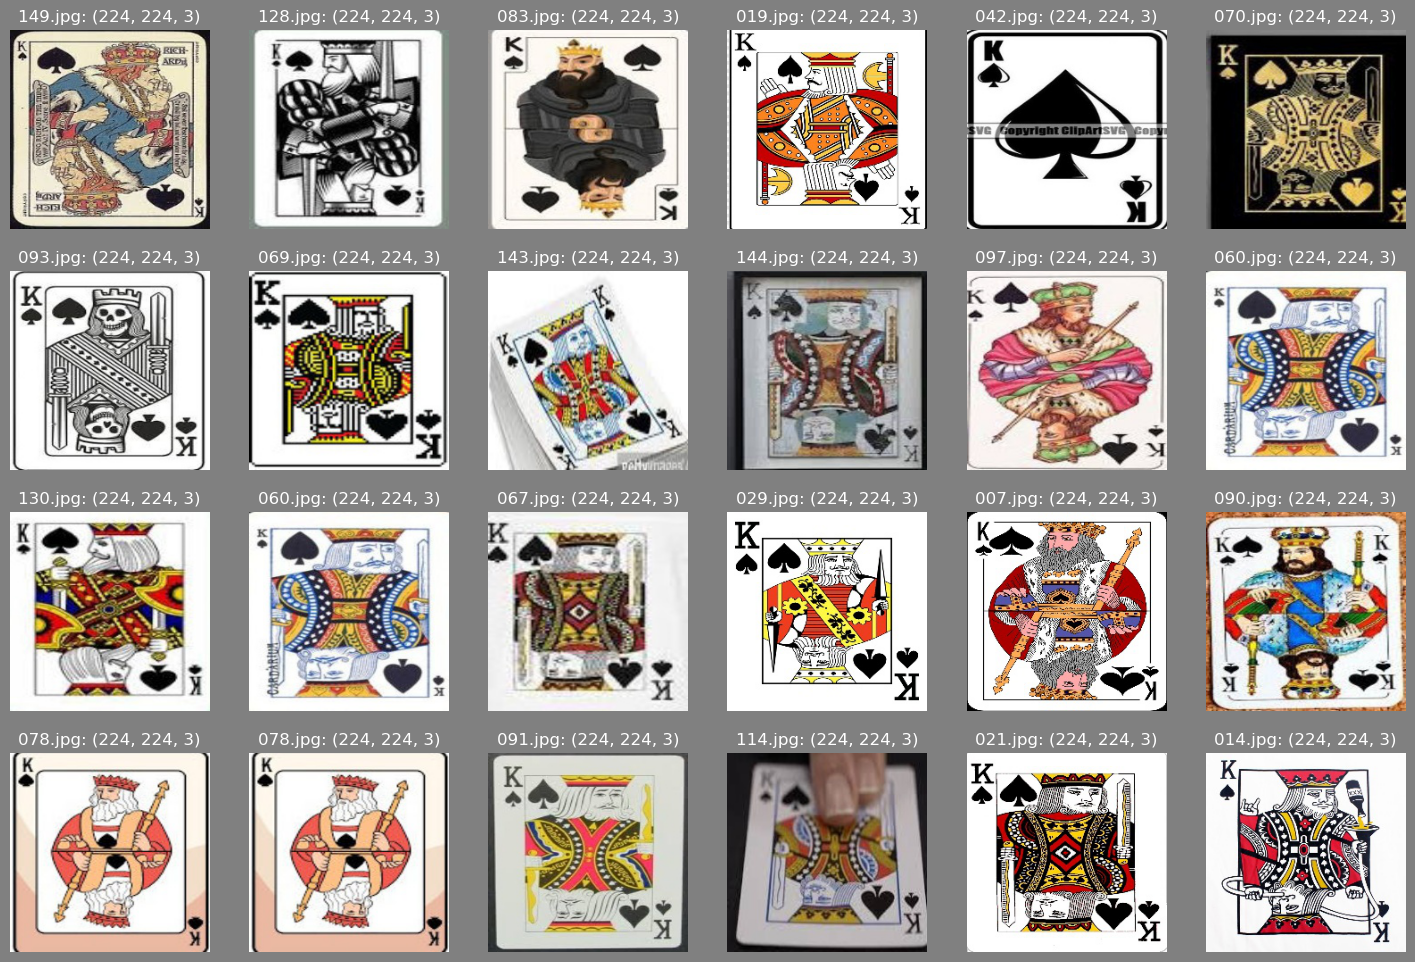

In [9]:
soml.data.image.show_random_image_from_disk(target_dir=TRAIN_DIR, target_class='king of spades')

# Create EfficientNetB0 Model

More details about EfficientNet can be found here:

https://paperswithcode.com/method/efficientnet

### Create datasets

In [10]:
# Set image shape back to 224x224 since the EfficientNetB0 model is based upon this size.
IMG_SHAPE = (224, 224)
BATCH_SIZE = 32

# Because we changed the image size we will also need to reload the datasets.
train_dataset = soml.data.loader.load_image_dataset_from_directory(directory=TRAIN_DIR, image_size=IMG_SHAPE, batch_size=BATCH_SIZE)
test_dataset = soml.data.loader.load_image_dataset_from_directory(directory=TEST_DIR, image_size=IMG_SHAPE, batch_size=BATCH_SIZE)
valid_dataset = soml.data.loader.load_image_dataset_from_directory(directory=VALID_DIR, image_size=IMG_SHAPE, batch_size=BATCH_SIZE, shuffle=False)

train_dataset = soml.tf.dataset.add_prefetching(dataset=soml.tf.dataset.add_shuffling(dataset=soml.tf.dataset.add_caching(dataset=soml.tf.dataset.add_rescaling_mapping(dataset=train_dataset))))
test_dataset = soml.tf.dataset.add_prefetching(dataset=soml.tf.dataset.add_shuffling(dataset=soml.tf.dataset.add_caching(dataset=soml.tf.dataset.add_rescaling_mapping(dataset=test_dataset))))
valid_dataset = soml.tf.dataset.add_prefetching(dataset=soml.tf.dataset.add_caching(dataset=soml.tf.dataset.add_rescaling_mapping(dataset=valid_dataset)))

print('\nClass-names:')
class_names = soml.tf.dataset.get_class_names(dataset=train_dataset)
class_names[:10]

Found 7624 files belonging to 53 classes.
Found 265 files belonging to 53 classes.
Found 265 files belonging to 53 classes.
WARN: Dataset is already shuffled.
Buffer size for shuffle has been set to 1000
WARN: Dataset is already prefetched.
WARN: Dataset is already shuffled.
Buffer size for shuffle has been set to 1000
WARN: Dataset is already prefetched.
WARN: Dataset is already prefetched.

Class-names:


['ace of clubs',
 'ace of diamonds',
 'ace of hearts',
 'ace of spades',
 'eight of clubs',
 'eight of diamonds',
 'eight of hearts',
 'eight of spades',
 'five of clubs',
 'five of diamonds']

In [11]:
soml.tf.dataset.describe_pipeline(dataset=train_dataset)

_PrefetchDataset -> _ShuffleDataset -> CacheDataset -> _MapDataset -> _BatchDataset -> _ShuffleDataset -> _PrefetchDataset -> _ZipDataset

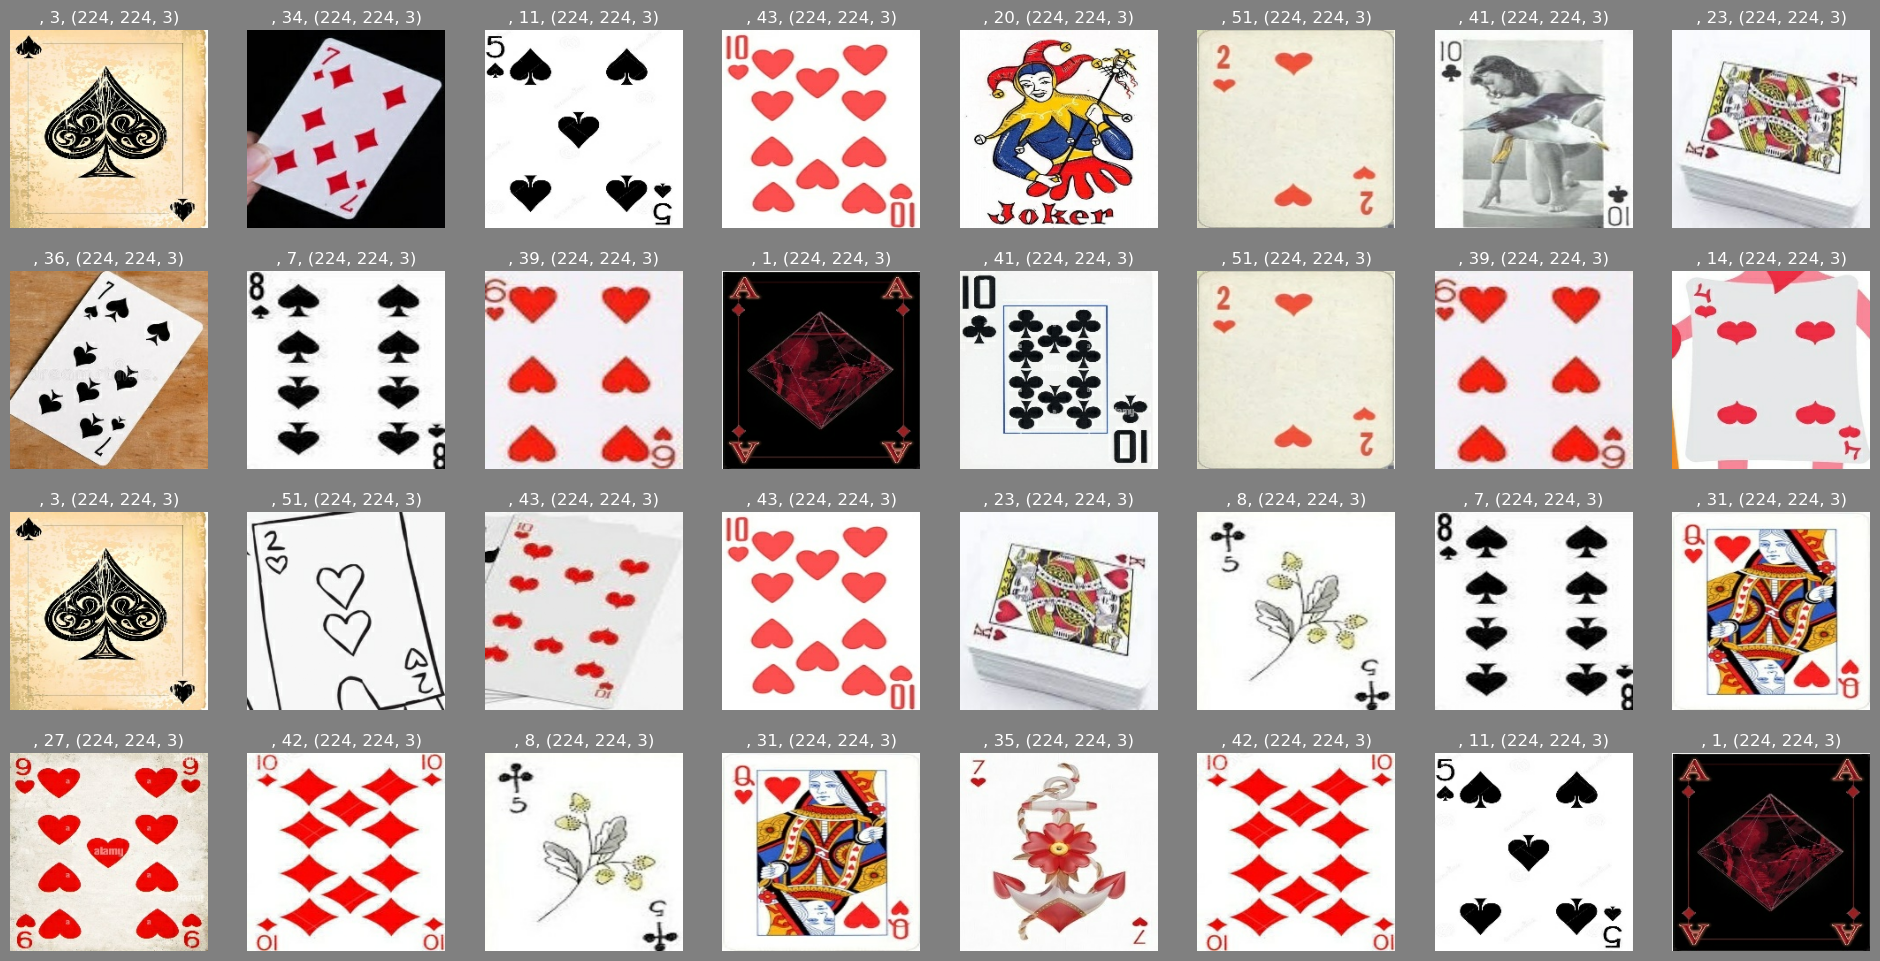

In [12]:
soml.tf.dataset.show_images_from_dataset(train_dataset)

### Perform feature extraction

In [14]:
# Create the EfficientNetB0 base model
vgg16_base_model = tf.keras.applications.vgg16.VGG16(include_top=False, weights=None)
vgg16_base_model.trainable = True

input_layer = ks.layers.Input(shape=IMG_SHAPE + (3,), name='input_layer')
x = vgg16_base_model(input_layer, training=False)
x = tf.keras.layers.GlobalAveragePooling2D(name='global_average_pooling')(x)
x = tf.keras.layers.Dense(units=64, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
output_layer = tf.keras.layers.Dense(len(class_names), activation='softmax', name='output_layer')(x)

vgg16_model = tf.keras.Model(input_layer, output_layer)

# 9. Compile the model
vgg16_model.compile(loss=ks.losses.CategoricalCrossentropy(),
                optimizer=ks.optimizers.Adam(learning_rate=0.001),
                metrics=["accuracy"])


In [15]:
soml.tf.model.inspect.list_model(model=vgg16_model, recursive=False)

row   | name (type)                                     | dtype   | policy  | trainable | output shape            | Total Param # | Trainable Param # | Non-trainable Param #
0     | input_layer            (InputLayer            ) | float32 | float32 | True      | [(None, 224, 224, 3)]   | 0             | 0                 | 0                    
1     | vgg16                  (Functional            ) | float32 | float32 | True      | (None, None, None, 512) | 14,714,688    | 14,714,688        | 0                    
2     | global_average_pooling (GlobalAveragePooling2D) | float32 | float32 | True      | (None, 512)             | 0             | 0                 | 0                    
3     | dense                  (Dense                 ) | float32 | float32 | True      | (None, 64)              | 32,832        | 32,832            | 0                    
4     | batch_normalization    (BatchNormalization    ) | float32 | float32 | True      | (None, 64)              | 256           

In [16]:
reduce_lr_on_plateau_callback = soml.tf.fit.callback.reduce_lr_on_plateau_callback()
early_stopping_callback = soml.tf.fit.callback.early_stopping_callback();
checkpoint_callback = soml.tf.fit.callback.model_checkpoint_callback(experiment_name='vgg16-no-weights', file_name='./best-weights.hdf5', verbose=0)

vgg16_history = vgg16_model.fit(train_dataset,
                              steps_per_epoch=len(train_dataset),
                              epochs=100,
                              validation_data=test_dataset,
                              validation_steps=len(test_dataset),
                              callbacks=[reduce_lr_on_plateau_callback, early_stopping_callback, checkpoint_callback])

Epoch 1/100
239/239 [==============================] - 21s 66ms/step - loss: 3.7684 - accuracy: 0.0383 - val_loss: 11.3844 - val_accuracy: 0.0189 - lr: 0.0010
Epoch 2/100
239/239 [==============================] - 15s 64ms/step - loss: 3.5900 - accuracy: 0.0464 - val_loss: 3.5405 - val_accuracy: 0.0453 - lr: 0.0010
Epoch 3/100
239/239 [==============================] - 15s 62ms/step - loss: 3.4931 - accuracy: 0.0576 - val_loss: 3.6215 - val_accuracy: 0.0340 - lr: 0.0010
Epoch 4/100
239/239 [==============================] - 15s 64ms/step - loss: 3.2506 - accuracy: 0.0883 - val_loss: 4.1392 - val_accuracy: 0.0302 - lr: 0.0010
Epoch 5/100
239/239 [==============================] - 15s 63ms/step - loss: 3.0100 - accuracy: 0.1512 - val_loss: 3.1198 - val_accuracy: 0.1208 - lr: 0.0010
Epoch 6/100
239/239 [==============================] - 15s 64ms/step - loss: 2.7009 - accuracy: 0.2501 - val_loss: 2.8099 - val_accuracy: 0.1811 - lr: 0.0010
Epoch 7/100
239/239 [==============================

### Evaluate the model

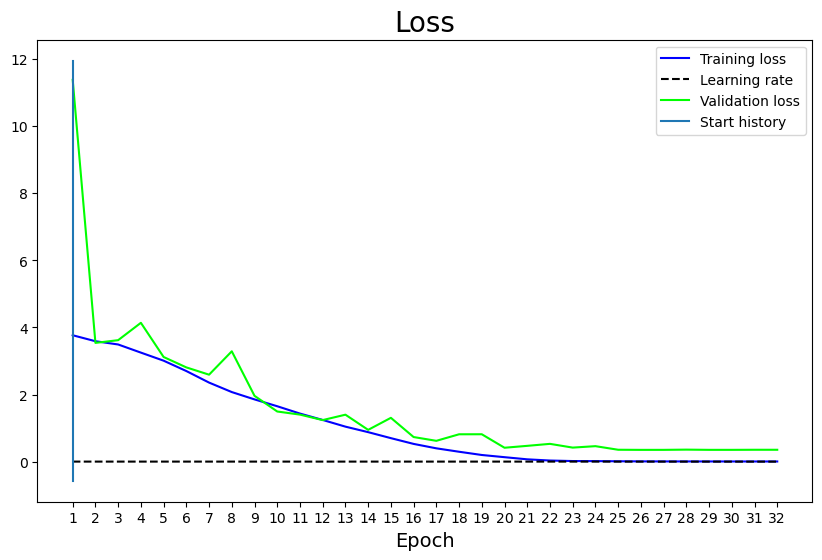

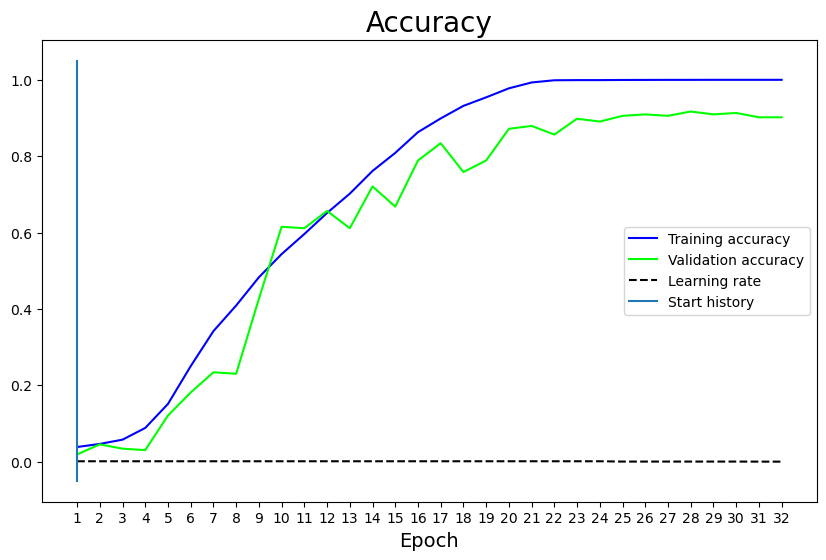

In [19]:
soml.tf.model.plot.plot_history(history=vgg16_history)

In [20]:
y_prob = vgg16_model.predict(valid_dataset)
len(y_prob)

9/9 [==============================] - 0s 23ms/step


265

In [21]:
y_true = soml.tf.dataset.get_labels(dataset=valid_dataset)
len(y_true)

265

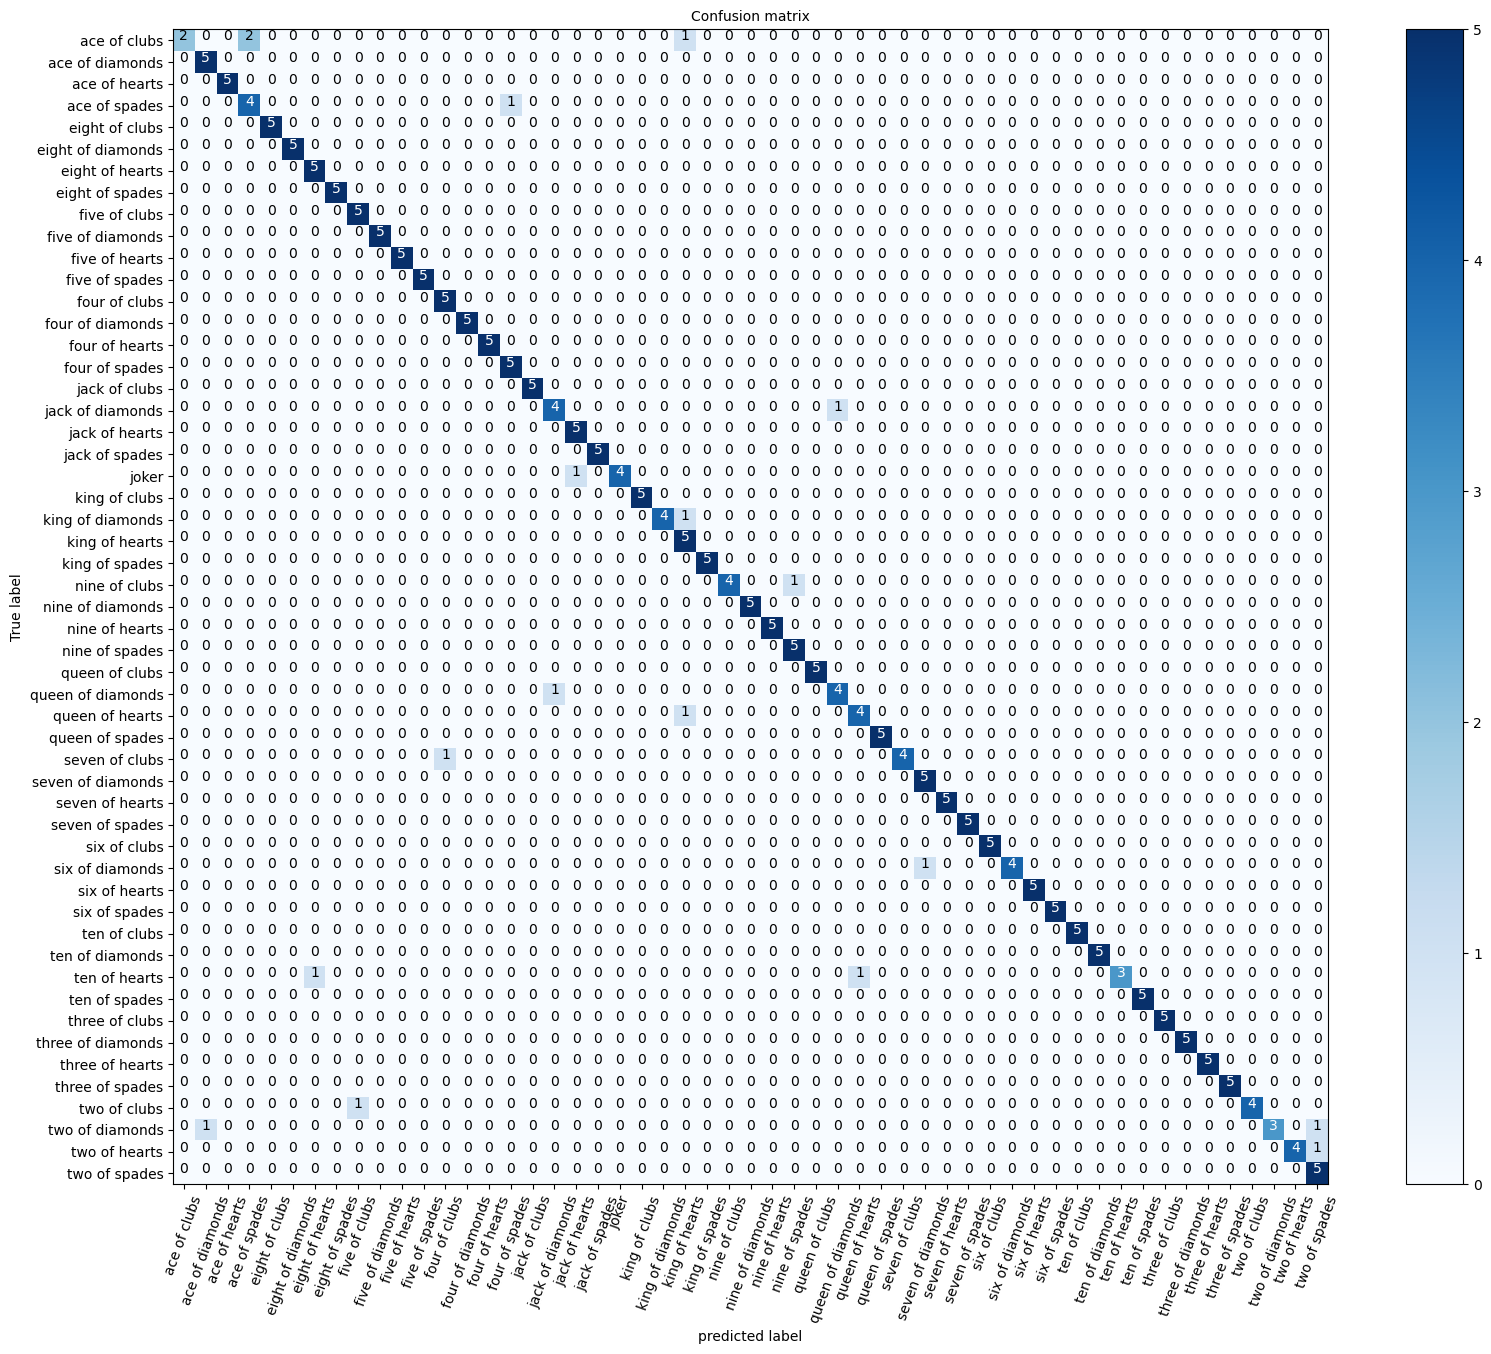

In [22]:
soml.evaluate.plot.confusion_matrix(y_true=y_true, y_prob=y_prob, class_names=class_names, figsize=(20, 15))

In [23]:
soml.evaluate.analyze.quality_metrics(y_true=y_true, y_prob=y_prob)

accuracy  f1-score  precision    recall
0  93.207547  0.930117   0.944766  0.932075